# Các thay đổi so với NS-ES và NSR-ES
------------
* Ý tưởng ban đầu của NS-ES (NSR-ES) đó là sử dụng một quần thể duy trì một số lượng cá thể nhất định qua từng **vòng lặp**.
* **Chọn lọc**: lựa chọn một trong số `m` cá thể của quần thể theo phân phối xác suất được tính theo 'novelty score'
* **Đột biến**: Mỗi worker (chạy song song) sẽ tiến hành đột biến cá thể này. Sau đó tính novelty score cho cá thể mới. Cuối cùng các kết quả từ mỗi worker sẽ được tổng hợp lại để thực hiện cập nhật cuối cùng trên cá thể được chọn ban đầu.
* Phép đột biến được thực hiện bằng cách thêm nhiễu `Gaussian` vào trọng số (tương tự như trong ES)
* Điểm khác biệt duy nhất của NS-ES và NSR-ES là NSR-ES có sử dụng thêm thông tin điểm thưởng để tiến hành cập nhật. Trong khi NS-ES chỉ sử dụng thông tin về tính mới trong hành vi

----------
* NS-ESc (NS-ES customized) và NSR-ESc tiến hành huấn luyện theo **thế hệ**.
* **Chọn lọc**: Chọn ra `m` cá thể có novelty score cao nhất. `m` cá thể này sẽ được giữ lại và bổ sung vào quần thể ở thế hệ kế tiếp.
* **Đột biến**: Tiến hành đột biến trên `m` cá thể có novelty score cao nhất. Sau đó lựa chọn ngẫu nhiên các cá thể còn lại trong quần thể hiện tại để tiến hành đột biến cho đến khi quần thể được lựa chọn có đủ số lượng.
* Tương tự như NS-ES và NSR-ES thì NS-ESc chỉ quan tâm đến tính mới trong hành vi trong khi NSR-ESc có sử dụng thêm thông tin về điểm thưởng. Còn phép đột biến được thực hiện bằng cách thêm nhiễu `Gaussian` vào trọng số của mạng

# Libraries

In [ ]:
!pip install moviepy==2.1.1
!pip install gymnasium

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
import gymnasium as gym
from moviepy import *
import os
import tqdm
from tqdm import tqdm
from torch.distributions.categorical import Categorical
from IPython.display import Video
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd '/content/drive/MyDrive/CS211.P11 - Đồ án cuối kỳ/'

# Neural Network

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        return self.model(state)

# Define used functions

In [ ]:
def display_video(video_path):
    return Video(video_path, embed=True, width=720, height=480)

def behavior_characterization(trajectory):      # Lấy trung bình các trạng thái
    return np.mean(trajectory, axis=0)

def evaluate_policy(env, policy, num_episodes=1, max_step_per_episode = 200, seed = 1):
    behaviors = []
    total_rewards = 0
    for _ in range(num_episodes):
        step = 0
        state = env.reset(seed=seed)
        done = False
        trajectory = []
        while not done:
            if type(state) == tuple:
                state = state[0]
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = policy(state_tensor)
            action = Categorical(action_probs).sample().item()
            next_state, reward, done, _, _ = env.step(action)
            trajectory.append(state)
            total_rewards += reward
            step += 1
            state = next_state
            if done or step == max_step_per_episode:
                break
        behaviors.append(behavior_characterization(trajectory))
    return np.mean(behaviors, axis=0), total_rewards / num_episodes         # Lấy trung bình trên các tập phát sinh

# Thay đổi hàm tính độ mới. Ở đây mỗi khi cập nhật archive, mỗi hành vi đều được coi là có sự đóng góp vào tính mới của archive
def compute_novelty(behavior_archive, k=5):
    novelty_scores = []
    for i in range(len(behavior_archive)):
        distances = [np.linalg.norm(behavior_archive[i] - b) for j, b in enumerate(behavior_archive) if i != j]
        novelty_scores.append(np.mean(sorted(distances)[:k]))
    return novelty_scores

def play(env_id, policy, seed = 1, max_step = 200, capture_video = True, video_output_path = 'output_video.mp4'):
    env = gym.make(env_id, render_mode='rgb_array')
    state = env.reset(seed=seed)
    frames = []
    done = False
    total_steps = 0
    total_rewards = 0

    while not done:
            frame = env.render()
            frames.append(frame)
            if total_steps + 1 == max_step:
                break
            if type(state) == tuple:
                state = state[0]
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = policy(state_tensor)
            action = Categorical(action_probs).sample().item()
            next_state, reward, done, truncated, info = env.step(action)
            total_rewards += reward
            state = next_state
            total_steps += 1
    env.close()

    if capture_video:
        clip = ImageSequenceClip(frames, fps=30)
        clip.write_videofile(video_output_path, codec="libx264")
    return total_steps, total_rewards

# NS-ESc

## Parameters & Hyperparameters

In [ ]:
# Parameters
env_id = 'CartPole-v0'
env = gym.make(env_id)
state_dim = 4           # obs space
action_dim = 2          # act space

# Hyperparameters
seed = 21521992
pop_size = 50     # Kích thước quần thể
max_gens = 100    # Số lượng thế hệ
num_episodes_per_eval = 3
distance_count = 5    # Tham số k (kNN) khi tính toán novelty
update_frequency = 10
max_step_per_episode = 500  # Giới hạn số bước tối đa cho mỗi tập
min_pops = 50   # Giới hạn số quần thể tối thiểu trước khi kiểm tra điều kiện dừng sớm
c_window = 10
c_threshold = 10
sigma = 0.1
alpha = 0.001

c:\Users\Duong\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\envs\registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


## Training

In [ ]:
# Tạo thư mục lưu trữ kết quả
save_dir = f"runs/NS-ESc/{env_id}__{seed}"
video_output_dir = f'videos/NS-ESc/{env_id}__{seed}'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)
if not os.path.exists(video_output_dir):
    os.makedirs(video_output_dir)
video_result_log = f'videos/NS-ESc/{env_id}__{seed}/video_log.txt'

In [ ]:
population = [NeuralNetwork(state_dim=state_dim, action_dim=action_dim) for _ in range(pop_size)]
all_pop_states = []
all_pop_rewards = []
all_pop_novelties = []
training_times = []

behavior_archive = []

for gen in range(max_gens):
    # Do mỗi quần thể là 1 mạng nơ-ron nên ta lưu trọng số của mô hình
    all_pop_states.append([policy.state_dict() for policy in population])

    pop_behaviors = []
    pop_rewards = []

    start_time = time.time()

    # Đánh giá quần thể
    for policy in population:
        behavior, reward = evaluate_policy(env, policy, num_episodes_per_eval, max_step_per_episode, seed)
        pop_behaviors.append(behavior)
        pop_rewards.append(reward)

    # Thêm các behavior vào archive
    behavior_archive.extend(pop_behaviors)

    # Đánh giá độ mới và xếp hạng quần thể
    novelties = compute_novelty(behavior_archive, k = distance_count)
    pop_novelties = novelties[-pop_size:]

    # Lưu kết quả
    all_pop_rewards.append(pop_rewards)
    all_pop_novelties.append(pop_novelties)

    # Lựa chọn 10 cá thể tốt nhất để giữ lại
    sorted_indices = np.argsort(pop_novelties)
    top_indices = sorted_indices[-10:]
    remain_indices = sorted_indices[:-10]
    new_population = [population[i] for i in top_indices]

    # Lấy 10 cá thể tốt nhất và 30 cá thể trong số 40 cá thể còn lại để tiến hành đột biến
    mutant_indices = []
    mutant_indices.extend(top_indices)
    while len(mutant_indices) < pop_size - 10:
        mutant_indices.append(np.random.choice(remain_indices, replace=False))

    for idx in mutant_indices:
        parent = population[idx]
        child = NeuralNetwork(state_dim=4, action_dim=2)
        for child_param, parent_param in zip(child.parameters(), parent.parameters()):
            noise = torch.normal(mean=0.0, std=sigma, size=parent_param.shape, device=parent_param.device)
            child_param.data = parent_param.data + noise  # Thêm nhiễu
        new_population.append(child)

    training_times.append(time.time() - start_time)

    # Kiểm tra điều kiện dừng sớm.
    stop = False
    all_best_rewards = np.max(all_pop_rewards, axis=1)
    if len(all_best_rewards) > min_pops:
        best_reward_buffer = all_best_rewards[-c_window:]
        if all(abs(x - best_reward_buffer[0]) <= c_threshold for x in best_reward_buffer):
            stop = True

    if (gen+1) % update_frequency == 0 or stop:
        # Lưu trạng thái quần thể
        np.savez_compressed(os.path.join(save_dir,f'results.npz'),
                            rewards = all_pop_rewards, novelties = all_pop_novelties, training_times = training_times)

        torch.save(all_pop_states, os.path.join(save_dir, f"Generation_{gen+1}.pt"))

        # Chơi game và lưu video
        best_population_index = np.argmax(all_best_rewards[-update_frequency:])
        best_population = all_pop_states[-update_frequency:][best_population_index]
        best_policy_state = best_population[np.argmax(all_pop_rewards[-update_frequency:][best_population_index])]
        best_policy = NeuralNetwork(state_dim=state_dim, action_dim=action_dim)
        best_policy.load_state_dict(best_policy_state)
        best_policy.eval()
        total_step, total_reward = play(env_id, best_policy, seed, max_step_per_episode, capture_video=True,
             video_output_path=os.path.join(video_output_dir,f'Generation_{gen+1}.mp4'))

        # Các kết quả của file video được lưu ở file log
        log = f'Generation: {gen+1}. Total step: {total_step}. Total reward: {total_reward}\n'
        with open(video_result_log, "a", encoding="utf-8") as file:
            file.write(log)

    if (gen+1) % 5 == 0 or stop:
        print(f"Generation {gen+1}/{max_gens}, Best new novelty: {np.max(all_pop_novelties[-5:]):.2f}, Best new reward: {np.max(all_pop_rewards):.2f}, Total executing time: {sum(training_times):.2f} seconds")

    # Cập nhật quần thể
    population = new_population

    if stop:
        print(f'Early stopping at generation {gen+1}')
        break

Generation 5/200, Best new novelty: 0.34, Best new reward: 49.67, Total executing time: 3.44 seconds


c:\Users\Duong\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\envs\registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


MoviePy - Building video videos/NS-ESc/CartPole-v0__21521992\Generation_10.mp4.
MoviePy - Writing video videos/NS-ESc/CartPole-v0__21521992\Generation_10.mp4



MoviePy - Done !
MoviePy - video ready videos/NS-ESc/CartPole-v0__21521992\Generation_10.mp4
Generation 10/200, Best new novelty: 0.19, Best new reward: 49.67, Total executing time: 8.20 seconds


Generation 15/200, Best new novelty: 0.13, Best new reward: 74.67, Total executing time: 15.64 seconds
MoviePy - Building video videos/NS-ESc/CartPole-v0__21521992\Generation_20.mp4.
MoviePy - Writing video videos/NS-ESc/CartPole-v0__21521992\Generation_20.mp4



MoviePy - Done !
MoviePy - video ready videos/NS-ESc/CartPole-v0__21521992\Generation_20.mp4
Generation 20/200, Best new novelty: 0.17, Best new reward: 74.67, Total executing time: 27.86 seconds
Generation 25/200, Best new novelty: 0.32, Best new reward: 94.67, Total executing time: 46.46 seconds
MoviePy - Building video videos/NS-ESc/CartPole-v0__21521992\Generation_30.mp4.
MoviePy - Writing video videos/NS-ESc/CartPole-v0__21521992\Generation_30.mp4



MoviePy - Done !
MoviePy - video ready videos/NS-ESc/CartPole-v0__21521992\Generation_30.mp4
Generation 30/200, Best new novelty: 0.32, Best new reward: 172.67, Total executing time: 80.27 seconds
Generation 35/200, Best new novelty: 0.35, Best new reward: 214.33, Total executing time: 117.23 seconds
MoviePy - Building video videos/NS-ESc/CartPole-v0__21521992\Generation_40.mp4.
MoviePy - Writing video videos/NS-ESc/CartPole-v0__21521992\Generation_40.mp4



MoviePy - Done !
MoviePy - video ready videos/NS-ESc/CartPole-v0__21521992\Generation_40.mp4
Generation 40/200, Best new novelty: 0.39, Best new reward: 224.67, Total executing time: 183.18 seconds
Generation 45/200, Best new novelty: 0.27, Best new reward: 364.00, Total executing time: 254.65 seconds
MoviePy - Building video videos/NS-ESc/CartPole-v0__21521992\Generation_50.mp4.
MoviePy - Writing video videos/NS-ESc/CartPole-v0__21521992\Generation_50.mp4



MoviePy - Done !
MoviePy - video ready videos/NS-ESc/CartPole-v0__21521992\Generation_50.mp4
Generation 50/200, Best new novelty: 0.36, Best new reward: 367.00, Total executing time: 331.80 seconds
Generation 55/200, Best new novelty: 0.40, Best new reward: 500.00, Total executing time: 423.16 seconds
MoviePy - Building video videos/NS-ESc/CartPole-v0__21521992\Generation_60.mp4.
MoviePy - Writing video videos/NS-ESc/CartPole-v0__21521992\Generation_60.mp4



MoviePy - Done !
MoviePy - video ready videos/NS-ESc/CartPole-v0__21521992\Generation_60.mp4
Generation 60/200, Best new novelty: 0.24, Best new reward: 500.00, Total executing time: 531.57 seconds
Generation 65/200, Best new novelty: 0.25, Best new reward: 500.00, Total executing time: 656.18 seconds
MoviePy - Building video videos/NS-ESc/CartPole-v0__21521992\Generation_70.mp4.
MoviePy - Writing video videos/NS-ESc/CartPole-v0__21521992\Generation_70.mp4



MoviePy - Done !
MoviePy - video ready videos/NS-ESc/CartPole-v0__21521992\Generation_70.mp4
Generation 70/200, Best new novelty: 0.24, Best new reward: 500.00, Total executing time: 804.61 seconds


## Results

In [ ]:
# Kết quả huấn luyện
result = np.load('runs/NS-ESc/CartPole-v0__21521992/results.npz')
all_pop_rewards = result['rewards']
all_pop_novelties = result['novelties']
training_times = result['training_times']

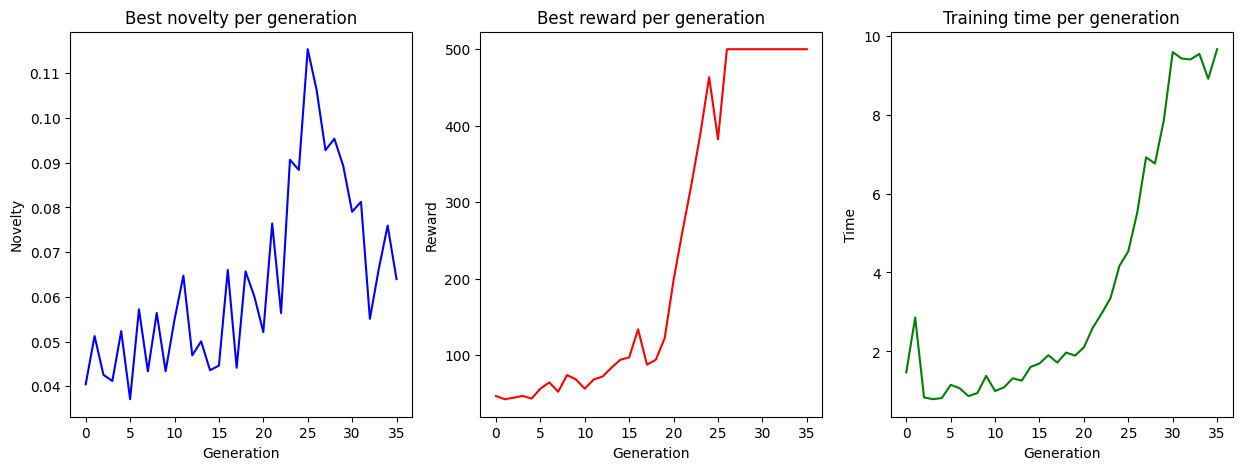

In [ ]:
generations = np.arange(all_pop_rewards.shape[0])
best_rewards  = np.max(all_pop_rewards, axis=1)
best_novelties = np.max(all_pop_novelties, axis=1)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(generations, best_rewards, label='Best Novelty', c='b')
plt.xlabel('Generation')
plt.ylabel('Novelty')
plt.title('Best novelty per generation')
plt.subplot(1, 3, 2)
plt.plot(generations, best_rewards, label='Best Reward', c='r')
plt.xlabel('Generation')
plt.ylabel('Reward')
plt.title('Best reward per generation')
plt.subplot(1,3,3)
plt.plot(generations, training_times, label='Training time', c='g')
plt.xlabel('Generation')
plt.ylabel('Time')
plt.title('Training time per generation')
plt.show()

In [ ]:
display_video('videos/NS-ES/CartPole-v0__NS-ES__21521992__36.mp4')

# NSR-ESc

## Parameters & Hyperparameters

In [ ]:
# Parameters
env_id = 'CartPole-v0'
env = gym.make(env_id)
state_dim = 4           # obs space
action_dim = 2          # act space

# Hyperparameters
seed = 21521992
pop_size = 50     # Kích thước quần thể
max_gens = 100    # Số lượng thế hệ
num_episodes_per_eval = 3
distance_count = 5    # Tham số k (kNN) khi tính toán novelty
update_frequency = 10
max_step_per_episode = 500  # Giới hạn số bước tối đa cho mỗi tập
min_pops = 50   # Giới hạn số quần thể tối thiểu trước khi kiểm tra điều kiện dừng sớm
c_window = 10
c_threshold = 10
novelty_weight = 0.5
reward_weight = 1 - novelty_weight
sigma = 0.1
alpha = 0.001

c:\Users\Duong\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\envs\registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


## Training

In [ ]:
# Tạo thư mục lưu trữ kết quả
save_dir = f"runs/NSR-ESc/{env_id}__{seed}"
video_output_dir = f'videos/NSR-ESc/{env_id}__{seed}'
if not os.path.exists(save_dir):
   os.makedirs(save_dir)
if not os.path.exists(video_output_dir):
    os.makedirs(video_output_dir)
video_result_log = f'videos/NSR-ESc/{env_id}__{seed}/video_log.txt'

In [ ]:
population = [NeuralNetwork(state_dim=state_dim, action_dim=action_dim) for _ in range(pop_size)]
all_pop_states = []
all_pop_rewards = []
all_pop_novelties = []
training_times = []

behavior_archive = []

for gen in range(max_gens):
    # Do mỗi quần thể là 1 mạng nơ-ron nên ta lưu trọng số của mô hình
    all_pop_states.append([policy.state_dict() for policy in population])

    pop_behaviors = []
    pop_rewards = []

    start_time = time.time()

    # Đánh giá quần thể
    for policy in population:
        behavior, reward = evaluate_policy(env, policy, num_episodes_per_eval, max_step_per_episode, seed)
        pop_behaviors.append(behavior)
        pop_rewards.append(reward)

    # Thêm các behavior vào archive
    behavior_archive.extend(pop_behaviors)

    # Đánh giá độ mới
    novelties = compute_novelty(behavior_archive, k = distance_count)
    pop_novelties = novelties[-pop_size:]

    # Lưu kết quả
    all_pop_rewards.append(pop_rewards)
    all_pop_novelties.append(pop_novelties)

    # Xếp hạng quần thể
    pop_scores = novelty_weight * np.array(pop_novelties) + reward_weight * np.array(pop_rewards)

    # Lựa chọn 10 cá thể tốt nhất để giữ lại
    sorted_indices = np.argsort(pop_scores)
    top_indices = sorted_indices[-10:]
    remain_indices = sorted_indices[:-10]
    new_population = [population[i] for i in top_indices]

    # Lấy 10 cá thể tốt nhất và 30 cá thể trong số 40 cá thể còn lại để tiến hành đột biến
    mutant_indices = []
    mutant_indices.extend(top_indices)
    while len(mutant_indices) < pop_size - 10:
        mutant_indices.append(np.random.choice(remain_indices, replace=False))

    for idx in mutant_indices:
        parent = population[idx]
        child = NeuralNetwork(state_dim=4, action_dim=2)
        for child_param, parent_param in zip(child.parameters(), parent.parameters()):
            noise = torch.normal(mean=0.0, std=sigma, size=parent_param.shape, device=parent_param.device)
            child_param.data = parent_param.data + noise  # Thêm nhiễu
        new_population.append(child)

    training_times.append(time.time() - start_time)

    # Kiểm tra điều kiện dừng sớm.
    stop = False
    all_best_rewards = np.max(all_pop_rewards, axis=1)
    if len(all_best_rewards) > min_pops:
        best_reward_buffer = all_best_rewards[-c_window:]
        if all(abs(x - best_reward_buffer[0]) <= c_threshold for x in best_reward_buffer):
            stop = True

    if (gen+1) % update_frequency == 0 or stop:
        # Lưu trạng thái quần thể
        np.savez_compressed(os.path.join(save_dir,f'results.npz'),
                            rewards = all_pop_rewards, novelties = all_pop_novelties, training_times = training_times)

        torch.save(all_pop_states, os.path.join(save_dir, f"Generation_{gen+1}.pt"))

        # Chơi game và lưu video
        best_population_index = np.argmax(all_best_rewards[-update_frequency:])
        best_population = all_pop_states[-update_frequency:][best_population_index]
        best_policy_state = best_population[np.argmax(all_pop_rewards[-update_frequency:][best_population_index])]
        best_policy = NeuralNetwork(state_dim=state_dim, action_dim=action_dim)
        best_policy.load_state_dict(best_policy_state)
        best_policy.eval()
        total_step, total_reward = play(env_id, best_policy, seed, max_step_per_episode, capture_video=True,
             video_output_path=os.path.join(video_output_dir,f'Generation_{gen+1}.mp4'))

        # Các kết quả của file video được lưu ở file log
        log = f'Generation: {gen+1}. Total step: {total_step}. Total reward: {total_reward}\n'
        with open(video_result_log, "a", encoding="utf-8") as file:
            file.write(log)

    if (gen+1) % 5 == 0 or stop:
        print(f"Generation {gen+1}/{max_gens}, Best new novelty: {np.max(all_pop_novelties[-5:]):.2f}, Best new reward: {np.max(all_pop_rewards):.2f}, Total executing time: {sum(training_times):.2f} seconds")

    # Cập nhật quần thể
    population = new_population

    if stop:
        print(f'Early stopping at generation {gen+1}')
        break

## Results